In [1]:
%matplotlib inline
import numpy as np
import nengo
import matplotlib.pyplot as plt

In [211]:
freq = 1.0

def func_x(t):
    return (np.sin(t*2*np.pi*freq), np.cos(t*2*np.pi*freq))

def func_y(t):
    return (np.cos(t*2*np.pi*freq), np.sin(t*2*np.pi*freq), 1.0)

class Memory(nengo.Node):
    def __init__(self, D, n_steps):
        self.mem = np.zeros((n_steps, D))
        super().__init__(self.update, size_in=D, size_out=D*n_steps)
    def update(self, t, x):
        self.mem = np.roll(self.mem, self.mem.shape[1])
        self.mem[0] = x
        return self.mem.flat

M = 100


model = nengo.Network()
with model:
    node_x = nengo.Node(func_x)
    node_y = nengo.Node(func_y)
    
    D = node_y.size_out
    
    state = nengo.Ensemble(n_neurons=500, dimensions=node_x.size_out, neuron_type=nengo.Direct())
    nengo.Connection(node_x, state, synapse=None)
    
    predict_y = nengo.Node(None, size_in=D*M)
    def ideal_predict(x):
        theta = np.arctan2(x[1], x[0])/(2*np.pi)
        dt = 0.001
        t = np.arange(M)*dt + theta
        return np.hstack([func_y(tt) for tt in t]).flatten()
    nengo.Connection(state, predict_y, function=ideal_predict, synapse=None)
    
    p_predict = nengo.Probe(predict_y)
    
    mem_predict = Memory(D*M, M)
    nengo.Connection(predict_y, mem_predict, synapse=None)
    
    p_predict_mem = nengo.Probe(mem_predict)
    
    error = nengo.Node(None, size_in=M*D)
    T = np.zeros((M*D, D))
    for i in range(D):
        T[i::D, i] = 1
    #nengo.Connection(node_y, error, transform=-T, synapse=None)
    T2 = np.zeros((M*D, D*M*M))
    for i in range(D):
        for j in range(M):
            T2[j*D+i, (j)*M*D+(j)*D+i] = 1
    nengo.Connection(mem_predict, error, transform=T2, synapse=None)
    
    p_error = nengo.Probe(error)
    
    
    mem_y = Memory(node_y.size_out, n_steps=M)
    nengo.Connection(node_y, mem_y, synapse=None)
    
    p_x = nengo.Probe(node_x)
    p_y = nengo.Probe(node_y)
    
    
    
    p_mem = nengo.Probe(mem_y)
sim = nengo.Simulator(model)
sim.run(0.5)
    
    
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

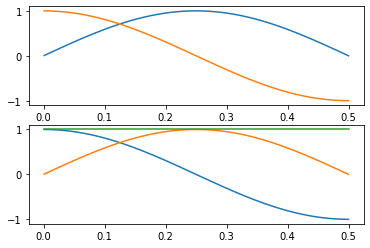

In [212]:
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_x])
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_y])
plt.show()

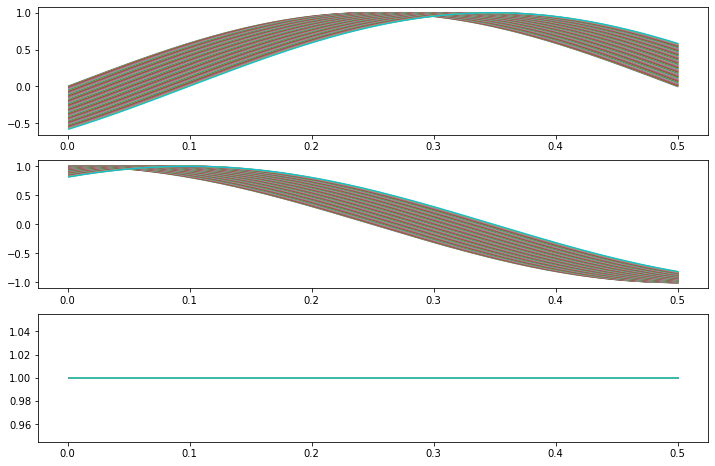

In [213]:
data = sim.data[p_predict]

plt.figure(figsize=(12,8))
D = node_y.size_out
for i in range(D):
    plt.subplot(D, 1, i+1)
    plt.plot(sim.trange(), data[:,i::D])
plt.show()

In [214]:
data = sim.data[p_predict_mem]

data.shape = data.shape[0], M, M, node_y.size_out



(-1, 1)

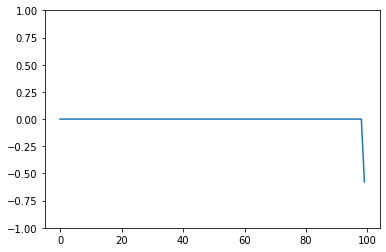

In [215]:
plt.plot([data[0, M-i-1, i, 0] for i in range(M)])
plt.ylim(-1,1)

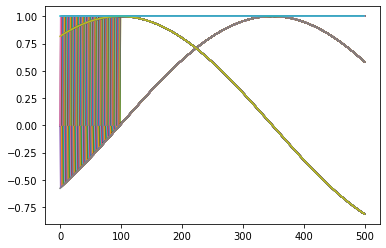

In [216]:
data = sim.data[p_error]
plt.plot(data)
plt.show()

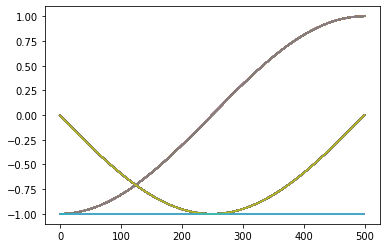

In [191]:
data = sim.data[p_error]
plt.plot(data)
plt.show()

In [210]:
data.shape

(500, 300)